
... ***CURRENTLY UNDER DEVELOPMENT*** ...


### TODO
- Plot complete with nans


In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.climate_emulator import Climate_Emulator
from teslakit.waves import AWL, Aggregate_WavesFamilies, Intradaily_Hydrograph
from teslakit.util.time_operations import xds_limit_dates, xds_reindex_daily, xds_common_dates_daily

from teslakit.plotting.climate_emulator import Plot_Simulation



## Database and Site parameters

In [4]:
# --------------------------------------
# Teslakit database
site = 'ROI'

p_data = r'/Users/albacid/Projects/TeslaKit_projects'
db = Database(p_data)

# set site
db.SetSite(site)


p_outputs = p_data + '/sites/' + site + '/ClimateChange_SLR_ENSO/'


# climate emulator object
CE = Climate_Emulator(p_outputs + 'EXTREMES/climate_emulator/')

CE.Load()

n_sims_DWTs = 10



## Simulated Waves and Climate Data

In [4]:
# --------------------------------------
# aux. functions

def waves_hourly(CE, n_sims_DWTs, n_sim_ce=0):
    '''
    Generate hourly simulation output. 
    
    - join DWTs-WVs Climate emulator simulations for all n_sims_DWTs
    - aggregate simulated waves storms
    - generate hourly hydrographs
    - calculates AWL
    
    return xarray.Dataset with dims: n_sim (DWTs-WVs), time (hourly)
    '''

    # iterate simulations
    ls_hy = []
    for n in range(n_sims_DWTs):
        _, TCS_sim, WVS_upd = CE.LoadSim(n_sim = n)    
        WVS_upd = WVS_upd.isel(n_sim = n_sim_ce)  # (one CE sim. for each DWT sim.)
        TCS_sim = TCS_sim.isel(n_sim = n_sim_ce)

        # Aggregate waves families
        wvs_agr = Aggregate_WavesFamilies(WVS_upd)

        # Calculate Intradaily hourly hydrographs for simulated storms
        hy = Intradaily_Hydrograph(wvs_agr, TCS_sim)
        ls_hy.append(hy)
        
    # combine hourly simulations
    hy = xr.concat(ls_hy, 'n_sim')

    # Calculate hourly Atmospheric Water Level and Total Water Level
    hy['AWL'] = AWL(hy.Hs, hy.Tp)

    return hy


In [5]:
# --------------------------------------
# Climate Emulator extremes model output

# Generate all MaxStorm DWTs-WVS-TCS simulations as a pandas.Dataframe (adding time and n_sim as columns)
WVS_sim = CE.LoadSim_All()
#db.Save_CE_AllSims(WVS_sim)

# Generate hourly waves xarray.Dataset using intradaily hydrographs
WVS_sim_h = waves_hourly(CE, n_sims_DWTs)  
#db.Save_SIM_Waves_hourly(WVS_sim_h)

print(WVS_sim_h)


<xarray.Dataset>
Dimensions:  (n_sim: 10, time: 8765833)
Coordinates:
  * time     (time) object 2000-01-01 2000-01-01T01:00:00 ... 3000-01-01
Dimensions without coordinates: n_sim
Data variables:
    Hs       (n_sim, time) float64 2.063 2.056 2.05 ... 0.3754 0.3539 0.3325
    Tp       (n_sim, time) float32 9.734059 9.734059 ... 6.9411745 13.976438
    Dir      (n_sim, time) float32 38.314224 38.314224 ... 45.322403 349.13596
    SS       (n_sim, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AWL      (n_sim, time) float64 0.6007 0.5997 0.5988 ... 0.1827 0.1774 0.3462
Attributes:
    source:   teslakit_v0.9.1



## Complete Simulation: load covariates and merge with hourly waves

In [6]:
# --------------------------------------
# Covariates: AWTs, DWTs, MJO, MMSL, AT

# Generate hourly covariates data
CVS_sim_h = db.Generate_SIM_Covariates(total_sims=n_sims_DWTs)
#db.Save_SIM_Covariates_hourly(CVS_sim_h)


# --------------------------------------
# Complete simulation output 
d1, d2 = xds_limit_dates([WVS_sim_h, CVS_sim_h])
WVS_sim_h = WVS_sim_h.sel(time = slice(d1, d2))
CVS_sim_h = CVS_sim_h.sel(time = slice(d1, d2))

# merge all data
SIM_COMPLETE = xr.merge([WVS_sim_h, CVS_sim_h])

# calculate TWL and level
SIM_COMPLETE['TWL'] = SIM_COMPLETE['AWL'] + SIM_COMPLETE['SS'] + SIM_COMPLETE['AT'] + SIM_COMPLETE['MMSL']
SIM_COMPLETE['level'] = SIM_COMPLETE['SS'] + SIM_COMPLETE['AT'] + SIM_COMPLETE['MMSL']

#db.Save_SIM_Complete_hourly(SIM_COMPLETE)

print(SIM_COMPLETE)


<xarray.Dataset>
Dimensions:  (n_sim: 10, time: 8765832)
Coordinates:
  * time     (time) object 2000-01-01 ... 2999-12-31T23:00:00
Dimensions without coordinates: n_sim
Data variables:
    Hs       (n_sim, time) float64 2.063 2.056 2.05 ... 0.3969 0.3754 0.3539
    Tp       (n_sim, time) float32 9.734059 9.734059 ... 6.9411745 6.9411745
    Dir      (n_sim, time) float32 38.314224 38.314224 ... 45.322403 45.322403
    SS       (n_sim, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AWL      (n_sim, time) float64 0.6007 0.5997 0.5988 ... 0.1879 0.1827 0.1774
    AWT      (n_sim, time) int64 5 5 5 5 5 5 5 5 5 5 5 ... 3 3 3 3 3 3 3 3 3 3 3
    MJO      (n_sim, time) int64 23 23 23 23 23 23 23 ... 25 25 25 25 25 25 25
    DWT      (n_sim, time) int64 27 27 27 27 27 27 27 ... 16 16 16 16 16 16 16
    MMSL     (n_sim, time) float32 -0.022942495 -0.022942495 ... -0.101341076
    AT       (time) float32 1.2538135 1.307724 ... 0.57611704 0.38318345
    TWL      (n_sim, time) floa

In [7]:
# reindex complete simulation to daily and store it
SIM_COMPLETE_d = xds_reindex_daily(SIM_COMPLETE)
#db.Save_SIM_Complete_daily(SIM_COMPLETE_d)

print(SIM_COMPLETE_d)


<xarray.Dataset>
Dimensions:  (n_sim: 10, time: 365243)
Coordinates:
  * time     (time) object 2000-01-01 2000-01-02 ... 2999-12-30 2999-12-31
Dimensions without coordinates: n_sim
Data variables:
    Hs       (n_sim, time) float64 2.063 1.908 1.753 ... 0.3325 1.363 0.8476
    Tp       (n_sim, time) float32 9.734059 9.734059 ... 6.9411745 6.9411745
    Dir      (n_sim, time) float32 38.314224 38.314224 ... 45.322403 45.322403
    SS       (n_sim, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AWL      (n_sim, time) float64 0.6007 0.5777 0.5537 ... 0.172 0.3482 0.2746
    AWT      (n_sim, time) int64 5 5 5 5 5 5 5 5 5 5 5 ... 3 3 3 3 3 3 3 3 3 3 3
    MJO      (n_sim, time) int64 23 15 23 23 25 25 25 ... 18 19 19 25 25 25 25
    DWT      (n_sim, time) int64 27 27 27 27 21 26 26 ... 34 34 34 20 16 16 16
    MMSL     (n_sim, time) float32 -0.022942495 -0.022942495 ... -0.101341076
    AT       (time) float32 1.2538135 1.2233721 ... 0.41754416 0.34369332
    TWL      (n_sim

In [8]:
# Prepare storms version (waves by families, used at nearshore RBF reconstruction)

n_sim_ce = 0  # (one CE sim. for each DWT sim.)

# iterate each DWT-WVS simulation
l_sims = []
for n in range(n_sims_DWTs):
    _, _, WVS_upd = CE.LoadSim(n_sim = n)    
    WVS_upd = WVS_upd.isel(n_sim = n_sim_ce) 

    # aggregated Hs, Tp, Dir
    WVS_a = Aggregate_WavesFamilies(WVS_upd)
    for vn in ['Hs', 'Tp', 'Dir']:
        WVS_upd[vn] = WVS_a[vn]
    
    # fix min and max times
    SIM_d = SIM_COMPLETE_d.isel(n_sim=n)
    
    dcs = xds_common_dates_daily([WVS_upd, SIM_d])
    WVS_upd = WVS_upd.sel(time=slice(dcs[0], dcs[-1]))
    SIM_d = SIM_d.sel(time=slice(dcs[0], dcs[-1]))
    
    # add all variables to storms version file
    SIM_COMPLETE_ms = WVS_upd.copy()
    for vn in SIM_d.variables:
        if vn not in SIM_COMPLETE_ms:
            SIM_COMPLETE_ms[vn] = SIM_d[vn].sel(time=SIM_COMPLETE_ms.time)   
    l_sims.append(SIM_COMPLETE_ms)
    
    
# store complete data for each simulation
#db.Save_SIM_Complete_storms(l_sims)


[4 4 4 ... 1 1 1]
<xarray.DataArray 'MJO' (time: 8765832)>
array([22, 22, 22, ..., 15, 15, 15])
Coordinates:
  * time     (time) object 2000-01-01 ... 2999-12-31T23:00:00
<xarray.DataArray 'DWT' (time: 8765832)>
array([26, 26, 26, ..., 11, 11, 11])
Coordinates:
  * time     (time) object 2000-01-01 ... 2999-12-31T23:00:00


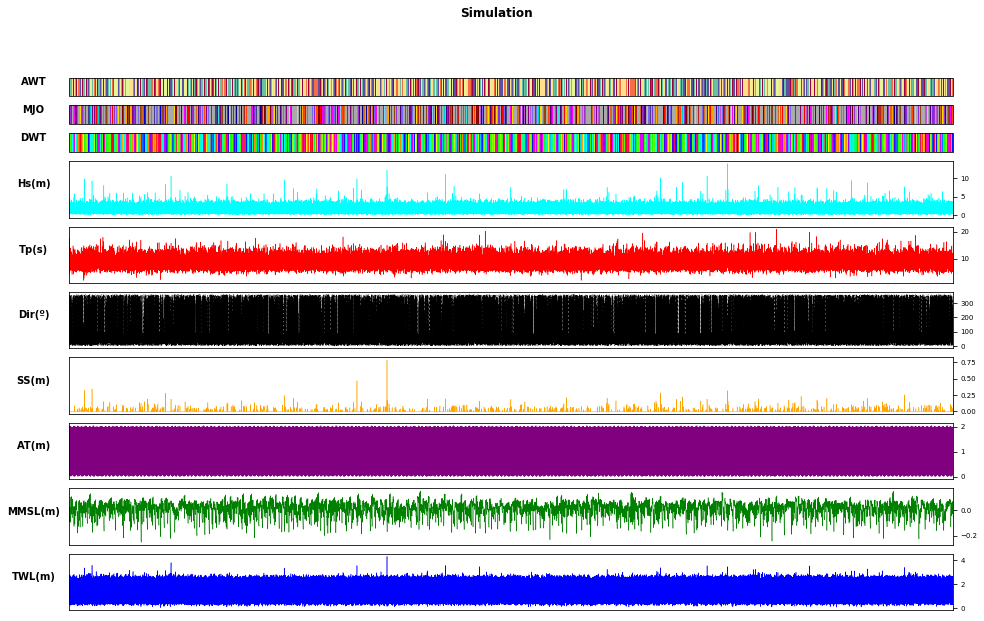

In [9]:
# Plot Simulation 

Plot_Simulation(SIM_COMPLETE.sel(n_sim=0));
